In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
ls

drive/  sample_data/


In [3]:
cd drive/MyDrive/Trash/code

/content/drive/MyDrive/Trash/code


In [4]:
!pip install albumentations==0.5.2

     |████████████████████████████████| 81kB 3.8MB/s 
     |████████████████████████████████| 37.6MB 75.6MB/s 
     |████████████████████████████████| 952kB 53.0MB/s 
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [5]:
import os
import random
import time
import json
import warnings 
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from utils import label_accuracy_score
import cv2

import numpy as np
import pandas as pd

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO
import torchvision
import torchvision.transforms as transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

plt.rcParams['axes.grid'] = False

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))

print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())

device = "cuda" if torch.cuda.is_available() else "cpu"   # GPU 사용 가능 여부에 따라 device 정보 저장

pytorch version: 1.8.1+cu101
GPU 사용 가능 여부: True
Tesla P100-PCIE-16GB
1


## 하이퍼파라미터 세팅 및 seed 고정

In [6]:
batch_size = 8   # Mini-batch size
num_epochs = 20
learning_rate = 0.0001

In [7]:
# seed 고정
random_seed = 42
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
# torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

## 학습 데이터 EDA

In [8]:
%matplotlib inline

dataset_path = '../input/data'
anns_file_path = dataset_path + '/' + 'train.json'

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1

print('Number of super categories:', nr_super_cats)
print('Number of categories:', nr_cats)
print('Number of annotations:', nr_annotations)
print('Number of images:', nr_images)

Number of super categories: 11
Number of categories: 11
Number of annotations: 21116
Number of images: 2617


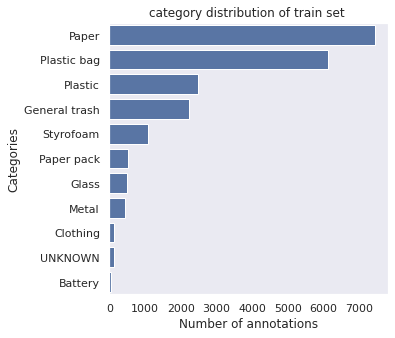

In [9]:
# Count annotations
cat_histogram = np.zeros(nr_cats,dtype=int)
for ann in anns:
    cat_histogram[ann['category_id']] += 1

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,5))

# Convert to DataFrame
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)

# Plot the histogram
plt.title("category distribution of train set ")
plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df, label="Total", color="b")

In [10]:
# category labeling 
sorted_temp_df = df.sort_index()

# background = 0 에 해당되는 label 추가 후 기존들을 모두 label + 1 로 설정
sorted_df = pd.DataFrame(["Backgroud"], columns = ["Categories"])
sorted_df = sorted_df.append(sorted_temp_df, ignore_index=True)

In [11]:
# class (Categories) 에 따른 index 확인 (0~11 : 총 12개)
sorted_df

,Categories,Number of annotations
0,Backgroud,NaN
1,UNKNOWN,128.0
2,General trash,2225.0
3,Paper,7448.0
4,Paper pack,527.0
5,Metal,449.0
6,Glass,488.0
7,Plastic,2472.0
8,Styrofoam,1074.0
9,Plastic bag,6114.0


## 데이터 전처리 함수 정의 (Dataset)

In [12]:
category_names = list(sorted_df.Categories)

def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

class CustomDataLoader(Dataset):
    """COCO format"""
    def __init__(self, data_dir, mode = 'train', transform = None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)
        
    def __getitem__(self, index: int):
        # dataset이 index되어 list처럼 동작
        image_id = self.coco.getImgIds(imgIds=index)
        image_infos = self.coco.loadImgs(image_id)[0]
        
        # cv2 를 활용하여 image 불러오기
        images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        images /= 255.0
        
        if (self.mode in ('train', 'val')):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            anns = self.coco.loadAnns(ann_ids)

            # Load the categories in a variable
            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)

            # masks : size가 (height x width)인 2D
            # 각각의 pixel 값에는 "category id + 1" 할당
            # Background = 0
            masks = np.zeros((image_infos["height"], image_infos["width"]))
            # Unknown = 1, General trash = 2, ... , Cigarette = 11
            for i in range(len(anns)):
                className = get_classname(anns[i]['category_id'], cats)
                pixel_value = category_names.index(className)
                masks = np.maximum(self.coco.annToMask(anns[i])*pixel_value, masks)
            masks = masks.astype(np.float32)

            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images, mask=masks)
                images = transformed["image"]
                masks = transformed["mask"]
            
            return images, masks, image_infos
        
        if self.mode == 'test':
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images)
                images = transformed["image"]
            
            return images, image_infos
    
    
    def __len__(self) -> int:
        # 전체 dataset의 size를 return
        return len(self.coco.getImgIds())

## Dataset 정의 및 DataLoader 할당

In [13]:
# train.json / validation.json / test.json 디렉토리 설정
train_path = dataset_path + '/train.json'
val_path = dataset_path + '/val.json'
test_path = dataset_path + '/test.json'

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

train_transform = A.Compose([
                            ToTensorV2()
                            ])

val_transform = A.Compose([
                          ToTensorV2()
                          ])

test_transform = A.Compose([
                           ToTensorV2()
                           ])

# create own Dataset 1 (skip)
# validation set을 직접 나누고 싶은 경우
# random_split 사용하여 data set을 8:2 로 분할
# train_size = int(0.8*len(dataset))
# val_size = int(len(dataset)-train_size)
# dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=transform)
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# create own Dataset 2
# train dataset
train_dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=train_transform)

# validation dataset
val_dataset = CustomDataLoader(data_dir=val_path, mode='val', transform=val_transform)

# test dataset
test_dataset = CustomDataLoader(data_dir=test_path, mode='test', transform=test_transform)


# DataLoader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=4,
                                           collate_fn=collate_fn,
                                           drop_last=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=4,
                                         collate_fn=collate_fn,
                                         drop_last=True)                                         

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          num_workers=4,
                                          collate_fn=collate_fn)

loading annotations into memory...
Done (t=3.85s)
creating index...
index created!
loading annotations into memory...
Done (t=3.25s)
creating index...
index created!
loading annotations into memory...
Done (t=0.51s)
creating index...
index created!


# wandb

In [ ]:
!pip install wandb

     |████████████████████████████████| 2.1MB 4.3MB/s 
     |████████████████████████████████| 133kB 36.3MB/s 
     |████████████████████████████████| 163kB 34.3MB/s 
     |████████████████████████████████| 102kB 13.4MB/s 
     |████████████████████████████████| 71kB 10.5MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=2de7dd8da7759d160deb90aec41a174a0805b6480a7c2ec10348f94031c5eb33
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=b1ffeee148a0368285ddc00ea711cdd2d892b8b36008b5a313ad9fda754a6099
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
Successfully built pathtools subprocess32


In [14]:
import wandb

proj_name = 're_pan_effb3_noisy_focal_madgrad_cosLR'

wandb.init(project='chanyub',name=proj_name)

config = wandb.config
config.learning_rate = 0.01

AttributeError: ignored

## My model

In [15]:
!pip install segmentation_models_pytorch

     |████████████████████████████████| 71kB 3.5MB/s 
     |████████████████████████████████| 245kB 8.2MB/s 
     |████████████████████████████████| 61kB 8.9MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp37-none-any.whl size=12420 sha256=4ca515854968cacdfb9b4854cb80de229ce128c68183a69c1031515364c1e168
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp37-none-any.whl size=60963 sha256=f55b554c00dc838956b2f60b74cd6919fcf71e457015a8f0750b8effdce1c857
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built efficientnet-pytorch pretrainedmodels


In [16]:
# 구현된 model에 임의의 input을 넣어 output이 잘 나오는지 test
import segmentation_models_pytorch as smp

model = smp.PAN(encoder_name='timm-efficientnet-b3', encoder_weights='noisy-student', classes=12)
x = torch.randn([2, 3, 512, 512])
print("input shape : ", x.shape)
out = model(x).to(device)
print("output shape : ", out.size())

model = model.to(device)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b3_ns-9d44bf68.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b3_ns-9d44bf68.pth



input shape :  torch.Size([2, 3, 512, 512])
output shape :  torch.Size([2, 12, 512, 512])


## train, validation, test 함수 정의

In [17]:
def train(num_epochs, model, data_loader, val_loader, criterion, optimizer, saved_dir, val_every, device, lr_scheduler):
    print('Start training..')
    best_loss = 9999999
    best_miou = 0
    for epoch in range(num_epochs):
        model.train()
        for step, (images, masks, _) in enumerate(data_loader):
            images = torch.stack(images)       # (batch, channel, height, width)
            masks = torch.stack(masks).long()  # (batch, channel, height, width)
            
            # gpu 연산을 위해 device 할당
            images, masks = images.to(device), masks.to(device)
                  
            # inference
            outputs = model(images)
            
            # loss 계산 (cross entropy loss)
            loss = criterion(outputs, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            lr_scheduler.step()
            
            # step 주기에 따른 loss 출력
            if (step + 1) % 25 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
                    epoch+1, num_epochs, step+1, len(train_loader), loss.item()))
        
        # validation 주기에 따른 loss 출력 및 best model 저장
        if (epoch + 1) % val_every == 0:
#             avrg_loss = validation(epoch + 1, model, val_loader, criterion, device)
#             if avrg_loss < best_loss:
#                 print('Best performance at epoch: {}'.format(epoch + 1))
#                 print('Save model in', saved_dir)
#                 best_loss = avrg_loss
#                 wandb.log({'best_loss': best_loss})
#                 save_model(model, saved_dir)
            avrg_miou = validation(epoch + 1, model, val_loader, criterion, device)
            if avrg_miou > best_miou:
                print('Best performance at epoch: {}'.format(epoch + 1))
                print('Save model in', saved_dir)
                best_miou = avrg_miou
                wandb.log({'best_miou': best_miou})
                save_model(model, saved_dir)

In [18]:
def validation(epoch, model, data_loader, criterion, device):
    print('Start validation #{}'.format(epoch))
    model.eval()
    with torch.no_grad():
        total_loss = 0
        cnt = 0
        mIoU_list = []
        for step, (images, masks, _) in enumerate(data_loader):
            
            images = torch.stack(images)       # (batch, channel, height, width)
            masks = torch.stack(masks).long()  # (batch, channel, height, width)

            images, masks = images.to(device), masks.to(device)            

            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss
            cnt += 1
            
#             print(outputs.shape)
#             print(masks.shape)
#             wandb.log(wandb.Image(images, masks={
#               "predictions" : {
#                 "mask_data" : torch.squeeze(torch.squeeze(outputs, 0),1),
#                 "class_labels" : classes_dict
#               },
#               "ground_truth" : {
#                 "mask_data" : torch.squeeze(masks, 0),
#                 "class_labels" : classes_dict
#               }
#             }))
            
            outputs = torch.argmax(outputs.squeeze(), dim=1).detach().cpu().numpy()

            mIoU = label_accuracy_score(masks.detach().cpu().numpy(), outputs, n_class=12)[2]
            mIoU_list.append(mIoU)
            
        avrg_loss = total_loss / cnt
        avrg_mIoU = np.mean(mIoU_list)
        print('Validation #{}  Average Loss: {:.4f}, mIoU: {:.4f}'.format(epoch, avrg_loss, np.mean(mIoU_list)))
        wandb.log({'Train Loss':loss.item(), 'Val Loss':avrg_loss , 'Val mIoU':np.mean(mIoU_list)})
#     return avrg_loss
    return avrg_mIoU

## 모델 저장 함수 정의

In [ ]:
# 모델 저장 함수 정의
val_every = 1 

saved_dir = './saved'
if not os.path.isdir(saved_dir):                                                           
    os.mkdir(saved_dir)
    
def save_model(model, saved_dir, file_name='re_pan_effb3_noisy_focal_madgrad_cosLR.pt'):
    check_point = {'net': model.state_dict()}
    output_path = os.path.join(saved_dir, file_name)
    torch.save(model.state_dict(), output_path)

## 모델 생성 및 Loss function, Optimizer 정의

In [ ]:
from torch.autograd import Variable
import torch.nn.functional as F
# ref : https://github.com/clcarwin/focal_loss_pytorch
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [ ]:
import torch.optim.lr_scheduler as lr_scheduler
import math
class CosineAnnealingWarmUpRestart(lr_scheduler._LRScheduler):
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError("Expected positive integer T_up, but got {}".format(T_up))
        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        self.T_cur = last_epoch
        super(CosineAnnealingWarmUpRestart, self).__init__(optimizer, last_epoch)
        # self.T_cur = last_epoch
    
    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [(self.eta_max - base_lr)*self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) * (1 + math.cos(math.pi * (self.T_cur-self.T_up) / (self.T_i - self.T_up))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch
                
        self.eta_max = self.base_eta_max * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

In [ ]:
# !pip install adamp

In [ ]:
!pip install madgrad

In [ ]:
# from adamp import AdamP
from madgrad import MADGRAD
# Loss function 정의
# criterion = nn.CrossEntropyLoss()
criterion = FocalLoss()

# Optimizer 정의
# optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate, weight_decay=1e-6)
# optimizer = AdamP(params = model.parameters())
optimizer = MADGRAD(params = model.parameters(), lr = learning_rate, momentum = 0.9, weight_decay = 0, eps = 1e-06)

# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 237, gamma = 0.65)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0)
# lr_scheduler = CosineAnnealingWarmUpRestart(optimizer, T_0=150, T_mult=1, eta_max=0.1,  T_up=10, gamma=0.5)

In [ ]:
train(num_epochs, model, train_loader, val_loader, criterion, optimizer, saved_dir, val_every, device, lr_scheduler)

Start training..
Epoch [1/20], Step [25/327], Loss: 0.8220
Epoch [1/20], Step [50/327], Loss: 0.9693
Epoch [1/20], Step [75/327], Loss: 0.5957
Epoch [1/20], Step [100/327], Loss: 0.5607
Epoch [1/20], Step [125/327], Loss: 0.6950
Epoch [1/20], Step [150/327], Loss: 0.3106
Epoch [1/20], Step [175/327], Loss: 0.4186
Epoch [1/20], Step [200/327], Loss: 0.4975
Epoch [1/20], Step [225/327], Loss: 0.4637
Epoch [1/20], Step [250/327], Loss: 0.3797
Epoch [1/20], Step [275/327], Loss: 0.2911
Epoch [1/20], Step [300/327], Loss: 0.3394
Epoch [1/20], Step [325/327], Loss: 0.9269
Start validation #1
Validation #1  Average Loss: 0.4036, mIoU: 0.3302
Best performance at epoch: 1
Save model in ./saved
Epoch [2/20], Step [25/327], Loss: 0.4637
Epoch [2/20], Step [50/327], Loss: 0.3740
Epoch [2/20], Step [75/327], Loss: 0.2870
Epoch [2/20], Step [100/327], Loss: 0.4495
Epoch [2/20], Step [125/327], Loss: 0.2755
Epoch [2/20], Step [150/327], Loss: 0.3229
Epoch [2/20], Step [175/327], Loss: 0.4972
Epoch [2

## 저장된 model 불러오기 (학습된 이후) 

In [22]:
# best model 저장된 경로
model_path = './saved/re_pan_aug2_re_pan_effb3_noisy_focal_madgrad_cosLReffb7_noisy_focal_madgrad_cosLR.pt'

# best model 불러오기
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint)

# 추론을 실행하기 전에는 반드시 설정 (batch normalization, dropout 를 평가 모드로 설정)
# model.eval()

<All keys matched successfully>

In [23]:
# 첫번째 batch의 추론 결과 확인
for imgs, image_infos in test_loader:
    image_infos = image_infos
    temp_images = imgs
    
    model.eval()
    # inference
    outs = model(torch.stack(temp_images).to(device))
    oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()
    
    break

i = 1
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 16))

print('Shape of Original Image :', list(temp_images[i].shape))
print('Shape of Predicted : ', list(oms[i].shape))
print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(oms[i]))])

# Original image
ax1.imshow(temp_images[i].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("Original image : {}".format(image_infos[i]['file_name']), fontsize = 15)

# Predicted
ax2.imshow(oms[i])
ax2.grid(False)
ax2.set_title("Predicted : {}".format(image_infos[i]['file_name']), fontsize = 15)

plt.show()

RuntimeError: ignored

## submission을 위한 test 함수 정의

In [ ]:
def test(model, data_loader, device):
    size = 256
    transform = A.Compose([A.Resize(256, 256)])
    print('Start prediction.')
    model.eval()
    
    file_name_list = []
    preds_array = np.empty((0, size*size), dtype=np.long)
    
    with torch.no_grad():
        for step, (imgs, image_infos) in enumerate(test_loader):

            # inference (512 x 512)
            outs = model(torch.stack(imgs).to(device))
            oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()
            
            # resize (256 x 256)
            temp_mask = []
            for img, mask in zip(np.stack(imgs), oms):
                transformed = transform(image=img, mask=mask)
                mask = transformed['mask']
                temp_mask.append(mask)

            oms = np.array(temp_mask)
            
            oms = oms.reshape([oms.shape[0], size*size]).astype(int)
            preds_array = np.vstack((preds_array, oms))
            
            file_name_list.append([i['file_name'] for i in image_infos])
    print("End prediction.")
    file_names = [y for x in file_name_list for y in x]
    
    return file_names, preds_array

## submission.csv 생성

In [ ]:
# sample_submisson.csv 열기
submission = pd.read_csv('./submission/sample_submission.csv', index_col=None)

# test set에 대한 prediction
file_names, preds = test(model, test_loader, device) # 여가

# PredictionString 대입
for file_name, string in zip(file_names, preds):
    submission = submission.append({"image_id" : file_name, "PredictionString" : ' '.join(str(e) for e in string.tolist())}, 
                                   ignore_index=True)

# submission.csv로 저장
submission.to_csv("./submission/pan_effb3_noisy_focal_adamp_cosLR.csv", index=False)

## 제출까지



In [ ]:
import json
import requests
import os
from urllib.parse import urlparse, parse_qsl, urlencode, urlunparse

def submit(user_key='', file_path = '', desc=""):
    if not user_key:
        raise Exception("No UserKey" )
    url = urlparse('http://ec2-13-124-161-225.ap-northeast-2.compute.amazonaws.com:8000/api/v1/competition/28/presigned_url/?description=&hyperparameters={%22training%22:{},%22inference%22:{}}')
    qs = dict(parse_qsl(url.query))
    qs['description'] = desc
    parts = url._replace(query=urlencode(qs))
    url = urlunparse(parts)

    print(url)
    headers = {
        'Authorization': user_key
    }
    res = requests.get(url, headers=headers)
    print(res.text)
    data = json.loads(res.text)
    
    submit_url = data['url']
    body = {
        'key':'app/Competitions/000028/Users/{}/Submissions/{}/output.csv'.format(str(data['submission']['user']).zfill(8),str(data['submission']['local_id']).zfill(4)),
        'x-amz-algorithm':data['fields']['x-amz-algorithm'],
        'x-amz-credential':data['fields']['x-amz-credential'],
        'x-amz-date':data['fields']['x-amz-date'],
        'policy':data['fields']['policy'],
        'x-amz-signature':data['fields']['x-amz-signature']
    }
    requests.post(url=submit_url, data=body, files={'file': open(file_path, 'rb')})


####################################################################################
test_dir = "/opt/ml/code/submission"  # 수정 필요 : output 파일 폴더 
desc = 'pan_effb3_noisy_focal_adamp_cosLR'  # 수정 필요 : 파일에 대한 설명
output_file = "pan_effb3_noisy_focal_adamp_cosLR.csv" #수정 필요  : output 파일 
user_key = "Bearer 7bb5f96452751a238ffaf91a93c4242bf9b72abe"        # 수정 필요 : Authorization 


submit(user_key, os.path.join(test_dir, output_file),desc)